**Part 8: Introduction to DNN regression using tensorflow**

   In the part 0 we did some basic prepossing. Parts 1-6 contained further data processing and linear regession predictions. Part 7 summarised the linear regression results and made some final predictions.

Here we do predictions with the DNN Regressor from tensorflow. DNN stands for Deep Neural Network, and we give a brief intuitive introduction to these in step 2 below. First however we must preprocess the data in a similar, but not identical, way to the linear regression preprocessing.

**Step 1: Data preprocessing**

Much of the code is the same as in part 7 for linear regression, but there are some differences:

    1. We investigate correlations after log transforming the train SalePrice, which is more appropriate in this case (WHY????).
    2. We do not do the one-hot encoding of the categorical features, because, as we shall see, the DNN-regressor in tensorflow has a different way of dealing with categorical features.
    3. We include the normalisation step (step 5 of part 0), as the DNN-regressor algorithms train better with scaled numerical features with values between 0 and 1.
    4. For the moment, we remove all considerations of outliers. This will be included when we give the fill code in part 9.
    
Other slight code changes are also needed. For example, when investigating weak and strong correlations, we now restrict our attention to the numerical features as we have not one-hot encoded the categorical features.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
lr = linear_model.LinearRegression()

# Import train and test data, save train SalePrice and test Id separately, remove train SalePrice and train and test Id
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train.drop(['Id'], axis=1, inplace=True)
submission = test[['Id']]
test.drop(['Id'], axis=1, inplace=True)
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)

# Split features/columns into numerical and categorical lists
numeric_features_columns = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold']
numeric_features_columns = list(set(numeric_features_columns) - set(categorical_features_list_to_remove_from_numerical))
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
categorical_features_columns = list(set(train.columns) - set(numeric_features_columns))

# The parameters we can change to alter the different components
categorical_parameter = .9 # Remove all categorical features which are dominated by a single category. More exactly, remove for which number_of_largest_category/total_number_of_house_data_points is > categorical_parameter and <= 1. If you want nothing removed, take > 1.
weak_correlations_paramenter = 0.05 # Remove all features whose train column is weakly correlated with train SalePrice. More exactly, remove for which the correlation is > -weak_correlation_parameter and  < +weak_correlation_parameter. If you want nothing removed, take < 0.
strong_correlations_paramenter = .8 # Remove 1 feature from all pairs of features when their train columns are strongly correlated. More exactly, remove 1 feature from all pairs of features when the correlation is > +strong_correlation_parameter and <= +1, or >= -1 and  < -strong_correlation_parameter. If you want nothing removed, take > 1.

# Fill in the missing data
latest_year_house_sold = train['YrSold'].max()
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
train_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if train[feature].isnull().sum() > 0]
test_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if test[feature].isnull().sum() > 0]
train_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if train[feature].isnull().sum() > 0]
test_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if test[feature].isnull().sum() > 0]

for feature in train_numeric_features_with_missing_values:
    train[feature].fillna(0, inplace = True)

for feature in test_numeric_features_with_missing_values:
    test[feature].fillna(0, inplace = True)

categoric_features_with_NA = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MiscFeature',
    'PoolQC'
]
for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        train[feature].fillna('NA', inplace = True)
    else:
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True)
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        test[feature].fillna('NA', inplace = True)
    else:
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True)

# Convert year features to age features
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt']
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt']
train['AgeOfSale'] = latest_year_house_sold - train['YrSold']
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt']
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt']
test['AgeOfSale'] = latest_year_house_sold - test['YrSold']
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale']
train.drop(year_features, axis=1, inplace=True)
test.drop(year_features, axis=1, inplace=True)
numeric_features_columns = list(set(numeric_features_columns) - set(year_features))
numeric_features_columns = list(set(numeric_features_columns).union(set(age_features)))

print('After basic data preprocessing:')
print('Number of numeric features = ' + str(len(numeric_features_columns)))
print('Number of categorical features = ' + str(len(categorical_features_columns)))
print('')

# Define categorical features to transform to numerical, and the chosen numerical transformations. If you want nothing transformed, leave list blank. If you want more transformed, add features to the list, and a numerical transformation for that feature below.
categorical_features_to_convert_to_numerical = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'ExterCond',
    'ExterQual',
    'Fence',
    'FireplaceQu',
    'Functional',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'HeatingQC',
    'KitchenQual',
    'LandSlope',
    'PavedDrive',
    'PoolQC',
    'Street',
    'Utilities'
]

def numerical_transformations(feature, x):
    if feature in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PoolQC']:
        if x == 'Ex':
            return 4
        elif x == 'Gd':
            return 3
        elif x == 'TA':
            return 2
        elif x == 'Fa':
            return 1
        else:
            return 0

    if feature in ['BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']: 
        if x == 'Ex':
            return 5
        elif x == 'Gd':
            return 4
        elif x == 'TA':
            return 3
        elif x == 'Fa':
            return 2
        elif x == 'Po':
            return 1
        else:
            return 0

    if feature in ['BsmtFinType1', 'BsmtFinType2']:
        if x == 'GLQ':
            return 6
        elif x == 'ALQ':
            return 5
        elif x == 'BLQ':
            return 4
        elif x == 'Rec':
            return 3
        elif x == 'LwQ':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'BsmtExposure':
        if x == 'Gd':
            return 4
        elif x == 'Av':
            return 3
        elif x == 'Mn':
            return 2
        elif x == 'No':
            return 1
        else:
            return 0

    if feature == 'Functional':
        if x == 'Typ':
            return 7
        elif x == 'Min1':
            return 6
        elif x == 'Min2':
            return 5
        elif x == 'Mod':
            return 4
        elif x == 'Maj1':
            return 3
        elif x == 'Maj2':
            return 2
        elif x == 'Sev':
            return 1
        else:
            return 0

    if feature == 'GarageFinish':
        if x == 'Fin':
            return 3
        elif x == 'RFn':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'Fence':
        if x == 'GdPrv':
            return 4
        elif x == 'MnPrv':
            return 3
        elif x == 'GdWo':
            return 2
        elif x == 'MnWw':
            return 1
        else:
            return 0

    if feature == 'BsmtQual':
        if x == 'Ex':
            return 105
        elif x == 'Gd':
            return 95
        elif x == 'TA':
            return 85
        elif x == 'Fa':
            return 75
        elif x == 'Po':
            return 65
        else:
            return 0
        
    if feature == 'CentralAir':
        if x == 'Y':
            return 1
        else:
            return 0
        
    if feature == 'Street':
        if x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'Alley':
        if x == 'Grvl' or x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'LandSlope':
        if x == 'Gtl':
            return 1
        else:
            return 0
        
    if feature == 'PavedDrive':
        if x == 'Y' or x == 'P':
            return 1
        else:
            return 0
    
    if feature == 'Utilities':
        if x == 'AllPub':
            return 1
        else:
            return 0

# Transform the chosen categorical features using the numerical chosen transformations
for feature in categorical_features_to_convert_to_numerical:
    train[feature] = train[feature].apply(lambda x: numerical_transformations(feature, x))
    test[feature] = test[feature].apply(lambda x: numerical_transformations(feature, x))
    categorical_features_columns.remove(feature)
    numeric_features_columns.append(feature)
    
print('After numerical transformations of some categorical features:')
print('Number of numeric features = ' + str(len(numeric_features_columns)))
print('Number of categorical features = ' + str(len(categorical_features_columns)))
print('')

# Remove categorical features with too few unique entries
train_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if train[feature].value_counts()[0]/len(train.index) > categorical_parameter]
test_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if test[feature].value_counts()[0]/len(test.index) > categorical_parameter]
categorical_features_list_with_too_few_unique_entries = list(set(train_categorical_features_with_few_unique_entries).union(set(test_categorical_features_with_few_unique_entries)))
categorical_features_columns = list(set(categorical_features_columns) - set(categorical_features_list_with_too_few_unique_entries))
train.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)
test.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)

print('After removing categorical features with little information:')
print('Number of numeric features = ' + str(len(numeric_features_columns)))
print('Number of categorical features = ' + str(len(categorical_features_columns)))
print('')

# Log transformation of train SalePrice
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log)

# Remove those features whose train column is weakly correlated with train SalePrice
train_correlations = pd.concat([train[numeric_features_columns], train_sale_price['SalePrice']], axis=1).corr() # We restrict our attention to the numeric features

features_with_low_correlation_to_sale_price = [feature for feature in numeric_features_columns if train_correlations[feature]['SalePrice'] < +weak_correlations_paramenter and train_correlations[feature]['SalePrice'] > -weak_correlations_paramenter] # All train featutes for which the correlation with train SalePrice is between -0.1 and +0.1.
numeric_features_columns = list(set(numeric_features_columns) - set(features_with_low_correlation_to_sale_price))
train.drop(features_with_low_correlation_to_sale_price, axis=1, inplace=True)
test.drop(features_with_low_correlation_to_sale_price, axis=1, inplace=True)

print('After removing features whose train column is weakly correlated with train SalePrice:')
print('Number of numeric features = ' + str(len(numeric_features_columns)))
print('Number of categorical features = ' + str(train.shape[1]-len(numeric_features_columns)))
print('')

# Remove 1 feature from every pair of features whose train columns are strongly correlated
train_correlations = pd.concat([train[numeric_features_columns], train_sale_price['SalePrice']], axis=1).corr() # We restrict our attention to the numeric features

feature_pairs_with_strong_correlation = []
features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice = []

for feature1 in numeric_features_columns:
    for feature2 in numeric_features_columns[numeric_features_columns.index(feature1)+1:]:
        if train_correlations[feature1][feature2] > +strong_correlations_paramenter or train_correlations[feature1][feature2] < -strong_correlations_paramenter:
            feature_pairs_with_strong_correlation.append([feature1, feature2])            
            if train_correlations[feature1]['SalePrice'] > train_correlations[feature2]['SalePrice']:
                features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice.append(feature2)
            else:
                features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice.append(feature1)


strongly_correlated_features_to_remove = list(set(features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice))
numeric_features_columns = list(set(numeric_features_columns) - set(strongly_correlated_features_to_remove))
train.drop(strongly_correlated_features_to_remove, axis=1, inplace=True)
test.drop(strongly_correlated_features_to_remove, axis=1, inplace=True)

print('After removing 1 feature from every pair of features whose train columns are strongly correlated:')
print('Number of numeric features = ' + str(len(numeric_features_columns)))
print('Number of categorical features = ' + str(train.shape[1]-len(numeric_features_columns)))
print('')

# Scale the train and test numeric features
numeric_train_feature_array = np.array(train[numeric_features_columns])
train_feature_scaler = MinMaxScaler()
train_feature_scaler.fit(numeric_train_feature_array)
train[numeric_features_columns] = pd.DataFrame(train_feature_scaler.transform(numeric_train_feature_array), columns = numeric_features_columns)
train_saleprice_array = np.array(train_sale_price)
train_salePrice_scaler = MinMaxScaler()
train_salePrice_scaler.fit(train_saleprice_array)
train_sale_price['SalePrice'] = pd.DataFrame(train_salePrice_scaler.transform(train_saleprice_array), columns = ['SalePrice'])
numeric_test_feature_array = np.array(test[numeric_features_columns])
test[numeric_features_columns] = pd.DataFrame(train_feature_scaler.transform(numeric_test_feature_array), columns = numeric_features_columns)

# The dataframes on which we will perform the regression
X = train.copy()
Y = train_sale_price.copy()

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.33)

After basic data preprocessing:
Number of numeric features = 34
Number of categorical features = 45

After numerical transformations of some categorical features:
Number of numeric features = 56
Number of categorical features = 23

After removing categorical features with little information:
Number of numeric features = 56
Number of categorical features = 18

After removing features whose train column is weakly correlated with train SalePrice:
Number of numeric features = 46
Number of one-hot encoded categorical features = 18

After removing 1 feature from every pair of features whose train columns are strongly correlated:
Number of numeric features = 39
Number of one-hot encoded categorical features = 18



/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Step 2: Initialise the DNN on the train-test split**

We will use the DNNRegressor library from tensorflow, which contains this and many other useful libraries for machine learning. First import tensorflow.

In [2]:
import tensorflow as tf
sess = tf.InteractiveSession()

/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will 

We will use the tf.contrib.learn.DNNRegressor. DNN stands for "Deep neural network". We give our own very brief intuitive introduction to DNNs here. We do not strive for total accuracy and clarity, as the literature is extensive, and recommend the interested reader to do their own research.

Previously with linear regression, we essentially assumed that the output (log of SalePrice) depends approximately linearly on the inputs (features), and we found the 'best' linear approximation. For DNNs we no longer assume linearly. Instead we assume that the output is a 'sufficiently well-behaved function' of the inputs that it can be estimated by a more general class of approximation functions. Moreover the 'best' such approximation can be 'approached' gradually over a series of steps, using gradient descent on a neural network or some similar process. Note the 'best' approximation will likely never be found: At each step the network 'learns', and then (hopefully) moves our approximation closer to the best, but probably never actually gets exactly there.

The neural network itself consists of an input layer, one or more hidden layers, and an output layer. Each layer consists of a number of 'nodes'. In our case, each node in the input layer represents an input feature, and so the number of nodes in the input layer equals the number of features. Each node in the input layer essentially 'contains' the value of that. The is only one single node in the output layer, 'containing' the SalePrice. The hidden layers can have whatever number of nodes we wish, and we can have as many hidden layers as we wish.

We now initialise the structure, specifying its structure.

In [3]:
def numeric_feature_column(feature):
    return tf.contrib.layers.real_valued_column(feature)
def embedded_feature_column(feature):
    categorical_column = tf.contrib.layers.sparse_column_with_hash_bucket(feature, hash_bucket_size=1000)
    return tf.contrib.layers.embedding_column(sparse_id_column=categorical_column, dimension=16,combiner="sum")

feature_cols = [
    numeric_feature_column(feature) for feature in numeric_features_columns
] + [
    embedded_feature_column(feature) for feature in categorical_features_columns
]

nodes = [200, 100, 50, 24]
activation_function = tf.nn.relu
drop = 0.35

# Initialise DNNRegressor on train test split
regressor = tf.contrib.learn.DNNRegressor(
    feature_columns = feature_cols,
    hidden_units=nodes,
    activation_fn = activation_function,
    dropout=drop
)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb4048d9590>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', 

'feature_columns = feature_cols' is essentially a list of the input features, in a specific tensorflow format. It tells tensorflow what types of input features to expect in the nodes of the input layer. The list contains a numeric_feature_column for each of our numeric features, and an embedded_feature_column for each of our categoric features. We will not discuss these encodings in greater detail, except to note that the categoric features can be encoded in other ways.

'hidden_units=nodes' is a list of integers, which gives the structure of the hidden layers. The above list means that we have 4 hidden layers (length of list = 4). The first layer of the DNN is the input layer, the next is the first hidden layer and has 200 nodes, the next hidden layer has 100, the next 50, the next 24, and finally we have the output layer of the DNN.

'activation_fn = activation_function' can be understood as follows: Each node in the input layer can be understood to contain the value of the associated input feature, and all such values are numbers. A node in the first hidden layer then takes all values from the nodes in the input layer, forms a linear combination of all the values, and then applies activation_function to the combination to produce a value which is 'contained' in this node. All the values produced are then processed in the same way by the next layer producing agin new values, which go to the next layer. This continues until we get to the output layer, and our approximation is the value that results from the above process.

'dropout=drop' is a number between 0 and 1 and represents the probability that a node in each hidden layer is dropped randomly. 0.35 means 35% of the nodes will be dropped. That means, the number of nodes in the first hidden layer is not actually 200, but actually a random 65 percent of the 200 nodes (130). If there is no drop parameter, neural network can approximate the training data 'too accurately', which can result in a decrease of accuracy on test data. This process is called over-fitting.

There are other possible parameters, for example the learning rate, or different optimisers (gradient descent, adam), but we will not discuss these.

**Step 3: Train the DNN on the train-test split**

We now train the regressor on the train-test split. First we need to give define an input function for the training, and the numer of training steps.

In [4]:
def input_fn_train(x, y): # x represents the input, and y the output, on which we will train. For example, we will take x = x_train and y = y_train
    
    continuous_cols = {feature: tf.constant(x[feature].values) for feature in numeric_features_columns} # A dictionary of (key, value) pairs, where key is a numeric feature, and value is tensor with the input training values (x) of this feature

    categorical_cols = {feature: tf.SparseTensor(
        indices=[[i, 0] for i in range(x[feature].size)], values = x[feature].values, dense_shape = [x[feature].size, 1]) for feature in categorical_features_columns} # A dictionary of (key, value) pairs, where key is a categoric feature, and value is tensor with the input training values (x) of this feature

    value_col = tf.constant(y['SalePrice'].values) # A tensor with the output training values (y)

    return {**continuous_cols, **categorical_cols}, value_col # Return a dictionary of input tensors, and also return the output tensor

steps = 1000

'steps' and represents the length of the training or 'learning' process: After an approximation has been made (output values obtained from the DNN) for all the training house data in the way described above, the values are compared to the actual sale prices, and an optimiser then attempts to improve how the values are combined (see previous paragraph) in an attempt to improve our approximation. The resulting new approximations are then compared to the actual sale prices again, and again new approximations produced. 'steps' gives the number of times this is done.

input_fn_train returns a pair of elements. The second element of the pair, value_col, is a tensor consisting of the train SalePrice values. The first element is a dictionary consisting of a (key, value) pairs for each of our input features, where key is the feature name, and value is a tensor consisting to the train column for that feature. We note that the tensor for numeric features is constructed using the tensorflow library tf.constant, and the tensor for the categoric features are constructed using the tensorflow library tf.SparseTensor. We will not describe these in detail, instead printing some examples to give some illustration.

In [5]:
input_tensors_dictionary, output_tensor = input_fn_train(x_train, y_train) # The input tensor dictionary, and the output tensor, for x_train and y_train

The output tensor is essentially an array with the 978 values contained in y_train.

In [6]:
print('Shape of y_train = ' + str(y_train.shape))
print('')
print('The output tensor = ' + str(output_tensor))
print('')
output_tensor.eval() # Print values of output tensor

Shape of y_train = (978, 1)

The output tensor = Tensor("Const_39:0", shape=(978,), dtype=float64)



array([0.44600979, 0.46774162, 0.61617055, 0.48707115, 0.5150269 ,
       0.27984608, 0.48497928, 0.81298265, 0.62241953, 0.59592408,
       0.58837653, 0.71306213, 0.54602983, 0.53542178, 0.61756962,
       0.32573677, 0.12970948, 0.53542178, 0.86713998, 0.30083946,
       0.37928577, 0.45187093, 0.50923533, 0.46384595, 0.58376249,
       0.49018394, 0.58822378, 0.39487974, 0.54341007, 0.28955679,
       0.4632856 , 0.64755564, 0.41239411, 0.43980006, 0.61406058,
       0.37342463, 0.61789056, 0.48914965, 0.45785652, 0.48287387,
       0.53301369, 0.31174388, 0.56445826, 0.57592393, 0.49733334,
       0.47409632, 0.57908206, 0.45876768, 0.6785007 , 0.7701927 ,
       0.62034985, 0.59065924, 0.65323486, 0.47366203, 0.43025736,
       0.46103449, 0.5914166 , 0.52630957, 0.46103449, 0.48497928,
       0.68875571, 0.61335421, 0.68875571, 0.7297002 , 0.45648498,
       0.61546874, 0.49934749, 0.43518601, 0.78198355, 0.37489984,
       0.74025774, 0.29712189, 0.49224271, 0.5150269 , 0.14795

input_tensors_dictionary is dictionary of (key, value) pairs, where each key is a features, and value is the tensor containing the values in the column of that feature in x_train. 

In [7]:
input_tensors_dictionary # Print the dictionary of the input tensors. Note that the keys are our input features.

{'BsmtUnfSF': <tf.Tensor 'Const:0' shape=(978,) dtype=float64>,
 'GarageFinish': <tf.Tensor 'Const_1:0' shape=(978,) dtype=float64>,
 'KitchenQual': <tf.Tensor 'Const_2:0' shape=(978,) dtype=float64>,
 '3SsnPorch': <tf.Tensor 'Const_3:0' shape=(978,) dtype=float64>,
 'Street': <tf.Tensor 'Const_4:0' shape=(978,) dtype=float64>,
 'PavedDrive': <tf.Tensor 'Const_5:0' shape=(978,) dtype=float64>,
 'OpenPorchSF': <tf.Tensor 'Const_6:0' shape=(978,) dtype=float64>,
 'LotFrontage': <tf.Tensor 'Const_7:0' shape=(978,) dtype=float64>,
 'GrLivArea': <tf.Tensor 'Const_8:0' shape=(978,) dtype=float64>,
 'TotalBsmtSF': <tf.Tensor 'Const_9:0' shape=(978,) dtype=float64>,
 'HalfBath': <tf.Tensor 'Const_10:0' shape=(978,) dtype=float64>,
 'KitchenAbvGr': <tf.Tensor 'Const_11:0' shape=(978,) dtype=float64>,
 'BsmtFullBath': <tf.Tensor 'Const_12:0' shape=(978,) dtype=float64>,
 'FireplaceQu': <tf.Tensor 'Const_13:0' shape=(978,) dtype=float64>,
 'AgeOfGarage': <tf.Tensor 'Const_14:0' shape=(978,) dtype

Take, for example, the numeric feature LotFrontage. Since this is numeric, the input tensor for LotFrontage is essentially an array with the 978 values contained in x_train LotFrontage column.

In [8]:
print('Shape of x_train LotFrontage column = ' + str(x_train['LotFrontage'].shape))
print('')
print('The input tensor for LotFrontage = ' + str(input_tensors_dictionary['LotFrontage']))
print('')
input_tensors_dictionary['LotFrontage'].eval() # Print the value of the input tensor for the numeric feature LotFrontage

Shape of x_train LotFrontage column = (978,)

The input tensor for LotFrontage = Tensor("Const_7:0", shape=(978,), dtype=float64)



array([0.25559105, 0.22364217, 0.23322684, 0.25239617, 0.24600639,
       0.        , 0.19169329, 0.24600639, 0.12460064, 0.28753994,
       0.23961661, 0.2715655 , 0.25559105, 0.        , 0.2428115 ,
       0.19169329, 0.17891374, 0.15335463, 0.20127796, 0.        ,
       0.        , 0.22364217, 0.25559105, 0.25559105, 0.2715655 ,
       0.19169329, 0.26837061, 0.22364217, 0.20766773, 0.33546326,
       0.22364217, 0.27795527, 0.15974441, 0.15974441, 0.33865815,
       0.        , 0.38338658, 0.19169329, 0.23642173, 0.11501597,
       0.18530351, 0.16613419, 0.        , 0.25559105, 0.        ,
       0.20766773, 0.1884984 , 0.        , 0.27476038, 0.25559105,
       0.        , 0.        , 0.28753994, 0.28753994, 0.        ,
       0.        , 0.45047923, 0.38338658, 0.19169329, 0.25559105,
       0.20766773, 0.23322684, 0.2715655 , 0.15974441, 0.20766773,
       0.20766773, 0.        , 0.23961661, 0.32907348, 0.15974441,
       0.2715655 , 0.15974441, 0.25559105, 0.2715655 , 0.22364

Categoric features are encoded in a more complicated way. Take, for example, the categoric feature MSZoning.

In [9]:
print('Shape of x_train MSZoning = ' + str(x_train['MSZoning'].shape))
print('')
print('The input tensor for the categoric feature MSZoning = ' + str(input_tensors_dictionary['MSZoning']))

Shape of x_train MSZoning = (978,)

The input tensor for the categoric feature MSZoning = SparseTensor(indices=Tensor("SparseTensor_14/indices:0", shape=(978, 2), dtype=int64), values=Tensor("SparseTensor_14/values:0", shape=(978,), dtype=string), dense_shape=Tensor("SparseTensor_14/dense_shape:0", shape=(2,), dtype=int64))


The input tensor for the train MSZoning column is a SparseTensor. Without getting into detail, this encodes the 978 categoric values contained in x_train MSZoning column as numbers. It uses 3 attributes: indices, values, and dense_shape. Lets look at each individually to get an idea of what they are.

In [10]:
print(input_tensors_dictionary['MSZoning'].eval().indices.shape)
input_tensors_dictionary['MSZoning'].eval().indices

(978, 2)


array([[  0,   0],
       [  1,   0],
       [  2,   0],
       ...,
       [975,   0],
       [976,   0],
       [977,   0]])

In [11]:
print(input_tensors_dictionary['MSZoning'].eval().values.shape)
input_tensors_dictionary['MSZoning'].eval().values

(978,)


array([b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL',
       b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL',
       b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RM', b'RL',
       b'RL', b'RL', b'C (all)', b'RL', b'RL', b'RM', b'RM', b'RL', b'RL',
       b'RL', b'RM', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RM',
       b'RL', b'RM', b'RM', b'RL', b'RL', b'RL', b'RL', b'RL', b'RM',
       b'RL', b'RL', b'RL', b'RL', b'RH', b'RL', b'RL', b'RL', b'RL',
       b'FV', b'RL', b'RL', b'RL', b'RL', b'RL', b'RM', b'FV', b'RM',
       b'RL', b'RL', b'RM', b'RL', b'RL', b'RL', b'FV', b'RL', b'RL',
       b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL',
       b'RL', b'RM', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL', b'RL',
       b'RL', b'RL', b'RL', b'RM', b'RM', b'RL', b'RL', b'RL', b'RL',
       b'RL', b'RL', b'RL', b'RL', b'RM', b'RM', b'RL', b'RL', b'RL',
       b'RL', b'RL', b'RL', b'RM', b'RL', b'RL', b'RM', b'RL', b'RL',
       b'RL', b

In [12]:
print(input_tensors_dictionary['MSZoning'].eval().dense_shape)
input_tensors_dictionary['MSZoning'].eval().dense_shape

[978   1]


array([978,   1])

We now train the regressor for the above number of steps, using x_train and y_train as training values, and using the above input function.

In [13]:
regressor.fit(input_fn = lambda: input_fn_train(x_train, y_train), steps=steps)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp7u71w0if/model.ckpt.
INFO:tensorflow:loss = 0.2798307, step = 1
INFO:tensorflow:global_step/sec: 44.8219
INFO:tensorflow:loss = 0.015256619, step = 101 (2.231 sec)
INFO:tensorflow:global_step/sec: 116.191
INFO:tensorflow:loss = 0.011157858, step = 201 (0.861 sec)
INFO:tensorflow:global_step/sec: 116.078
INFO:tensorflow:loss = 0.010277695, step = 301 (0.862 sec)
INFO:tensorflow:global_step/sec: 114.285
INFO:tensorflow:loss = 0.008791441, step = 401 (0.875 sec)
INFO:tensorflow:global_step/se

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7fb4681a70d0>, 'hidden_units': [200, 100, 50, 24], 'feature_columns': (_RealValuedColumn(column_name='BsmtUnfSF', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='GarageFinish', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='KitchenQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='3SsnPorch', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Street', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='PavedDrive', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OpenPorchSF', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_nam

We see above that the loss generally decreases at each step, as we move closer to the 'best' approximation. The loss is an internal metric used in the tensorflow training to optomize at each step.

We finally evaluate the loss in our train-test split using x_test and y_test.

In [14]:
regressor.evaluate(input_fn=lambda: input_fn_train(x_test, y_test), steps=1)

INFO:tensorflow:Starting evaluation at 2020-12-11T10:16:24Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmp7u71w0if/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2020-12-11-10:16:25
INFO:tensorflow:Saving dict for global step 1000: global_step = 1000, loss = 0.005572937


{'loss': 0.005572937, 'global_step': 1000}

Note, if the loss evaluated on x_test and y_test is significantly larger than the final loss in the training in x_train and y_train, this could be an indicator that our approximation has over-fitted on x_train and y_train. Altering the dropout rate may improve this.

**Step 4: Predicting the values of y_test using the trained regressor and x_test**

We will use the above trained regressor to predict y_test using only x_test. We begin by defining a prediction input function.

In [15]:
def input_fn_predict(x):
    continuous_columns = {feature: tf.constant(x[feature].values) for feature in numeric_features_columns}

    categorical_columns = {feature: tf.SparseTensor(
        indices=[[i, 0] for i in range(x[feature].size)], values = x[feature].values, dense_shape = [x[feature].size, 1]) for feature in categorical_features_columns}

    return {**continuous_columns, **categorical_columns}

This is very similar to the training input function, except now we now only return the input tensor dictionary, and not the output tensor. This is, of course, because we want to predict the outputs given the inputs.

Next we make a prediction.

In [16]:
actual_scaled_array = np.array(y_test) # An array containing the values to be predicted
number_of_values_to_predict = actual_scaled_array.shape[0] # The number of values to be predicted

predicted_scaled_array = np.array(list(regressor.predict(input_fn=lambda: input_fn_predict(x_test)))).reshape(number_of_values_to_predict,1) # Predict the actual values, and convert the result into an np array
predicted_scaled_array # Print the array

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7u71w0if/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([[0.42413867],
       [0.59597   ],
       [0.40574965],
       [0.46322542],
       [0.6544857 ],
       [0.3871178 ],
       [0.5379297 ],
       [0.49894238],
       [0.3934172 ],
       [0.41060597],
       [0.42008042],
       [0.40604264],
       [0.4082731 ],
       [0.5273619 ],
       [0.5186457 ],
       [0.42541552],
       [0.5596711 ],
       [0.41894516],
       [0.39327592],
       [0.5488157 ],
       [0.51278406],
       [0.5198287 ],
       [0.5378613 ],
       [0.42139506],
       [0.5382004 ],
       [0.4769583 ],
       [0.5459835 ],
       [0.39119712],
       [0.52211094],
       [0.539563  ],
       [0.4119473 ],
       [0.6021639 ],
       [0.51665163],
       [0.39684927],
       [0.5958814 ],
       [0.45651457],
       [0.42227575],
       [0.5598379 ],
       [0.5942614 ],
       [0.3685581 ],
       [0.40709406],
       [0.5515279 ],
       [0.4063016 ],
       [0.61984646],
       [0.40320748],
       [0.37275028],
       [0.40594852],
       [0.405

Recall that the train SalePrices were first log transformed, and then scaled using train_salePrice_scaler. Thus the values in actual_scaled_array are the log transformed and scaled SalePrices, and the values in predicted_scaled_array are our predictions for these values. To get simply the log transformed values, we must therfore perform the inverse of train_salePrice_scaler on both.

In [17]:
actual_log_prices = pd.DataFrame(train_salePrice_scaler.inverse_transform(actual_scaled_array), columns = ['SalePrice']) # Perform inverse scaling on array, then conver to a dataframe
predicted_log_prices = pd.DataFrame(train_salePrice_scaler.inverse_transform(predicted_scaled_array), columns = ['SalePrice']) # Perform inverse scaling on array, then conver to a dataframe
predicted_log_prices # Print the predicted log prices dataframe

,SalePrice
0,11.764143
1,12.292391
2,11.707610
3,11.884304
4,12.472282
...,...
477,11.771597
478,11.660557
479,12.111472
480,11.748837


Finally we calculate the RMSE between actual_log_prices and predicted_log_prices, and give a scatterplot.

0.22949785736702621


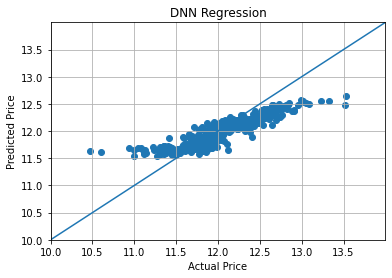

In [18]:
print(np.sqrt(mean_squared_error(actual_log_prices.values, predicted_log_prices.values)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('DNN Regression')
plt.show()

This result is not as good as those we obtained using linear regression, but of course this is just our first attempt. We will try different parameters in the next part.

**Step 5: Predicting the test values using a regressor trained on the whole of X and Y**

We train a new regressor on the whole of X and Y, and use this to predict the test SalePrices, and generate a submission file. The procedure is very similar to that for the train-test split.

In [19]:
# Initialise a new regressor using the same feature_columns, etc, as above
regressor = tf.contrib.learn.DNNRegressor(
    feature_columns = feature_cols,
    hidden_units=nodes,
    activation_fn = activation_function,
    dropout=drop
)

# Train the regressor using the whole of X and Y
regressor.fit(input_fn = lambda: input_fn_train(X, Y), steps=steps)

# The values to be predicted
X_test = test.copy()
number_of_values_to_predict = X_test.shape[0]

# Predict using the regressor and X_test
predicted_scaled_array = np.array(list(regressor.predict(input_fn=lambda: input_fn_predict(X_test)))).reshape(number_of_values_to_predict,1)
predicted_log_prices = pd.DataFrame(train_salePrice_scaler.inverse_transform(predicted_scaled_array), columns = ['SalePrice'])
submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp) # Inverse of the log transform

submission.to_csv('submission.csv',index=False)
submission

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3b5923490>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpciwjtfyn'}


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpciwjtfyn/model.ckpt.
INFO:tensorflow:loss = 0.3959417, step = 1
INFO:tensorflow:global_step/sec: 37.9025
INFO:tensorflow:loss = 0.015941462, step = 101 (2.639 sec)
INFO:tensorflow:global_step/sec: 80.0183
INFO:tensorflow:loss = 0.011925344, step = 201 (1.250 sec)
INFO:tensorflow:global_step/sec: 79.9803
INFO:tensorflow:loss = 0.010247698, step = 301 (1.250 sec)
INFO:tensorflow:global_step/sec: 82.1374
INFO:tensorflow:loss = 0.009309739, step = 401 (1.218 sec)
INFO:tensorflow:global_step/sec: 79.9741
INFO:tensorflow:loss = 0.009274315, step = 501 (1.250 sec)
INFO:tensorflow:global_step/sec: 81.1852
INFO:tensorflow:loss = 0.0084331045, step = 601 (1.232 sec)
INFO:tensorflow:global_step/sec: 84.1744
INFO:tensorflow:loss = 0.008396666, step = 701 (1.188 sec)
INFO:tensorflow:g

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpciwjtfyn/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Id,SalePrice
0,1461,120289.609375
1,1462,132912.750000
2,1463,171744.046875
3,1464,190256.390625
4,1465,159745.406250
...,...,...
1454,2915,123122.945312
1455,2916,124095.359375
1456,2917,135222.546875
1457,2918,125731.781250


Submission to kaggle gives an **RMSE of 0.24251**. Again, this is gignificantly worse than the results we obtained with linear regression, but this is just our first attempt.

**Step 6: DNN regressor using just the numeric features, ignoring the categoric features**

First the train-test split.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb384eacdd0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpcjarz6g9'}


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpcjarz6g9/model.ckpt.
INFO:tensorflow:loss = 0.25941575, step = 1
INFO:tensorflow:global_step/sec: 208.077
INFO:tensorflow:loss = 0.017326701, step = 101 (0.481 sec)
INFO:tensorflow:global_step/sec: 267.941
INFO:tensorflow:loss = 0.0128176315, step = 201 (0.373 sec)
INFO:tensorflow:global_step/sec: 265.673
INFO:tensorflow:loss = 0.011713139, step = 301 (0.376 sec)
INFO:tensorflow:global_step/sec: 280.127
INFO:tensorflow:loss = 0.009955333, step = 401 (0.357 sec)
INFO:tensorflow:global_step/sec: 266.148
INFO:tensorflow:loss = 0.009188845, step = 501 (0.376 sec)
INFO:tensorflow:global_step/sec: 248.63
INFO:tensorflow:loss = 0.009105826, step = 601 (0.402 sec)
INFO:tensorflow:global_step/sec: 251.313
INFO:tensorflow:loss = 0.008743894, step = 701 (0.398 sec)
INFO:tensorflow:g

INFO:tensorflow:Starting evaluation at 2020-12-11T10:33:13Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpcjarz6g9/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2020-12-11-10:33:13
INFO:tensorflow:Saving dict for global step 1000: global_step = 1000, loss = 0.010661537
{'loss': 0.010661537, 'global_step': 1000}


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpcjarz6g9/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.3174288336812804


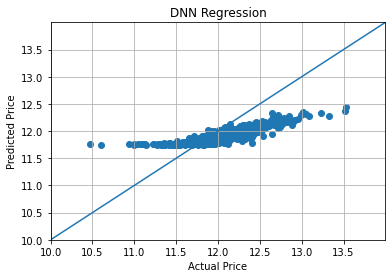

In [20]:
# Restrict to the numeric features. y_train and y_test are are unchanged from above
x_train = x_train[numeric_features_columns]
x_test = x_test[numeric_features_columns]

# Initialise the regressor for the train test split. Note feature_cols now contains no embedded columns
feature_cols = [numeric_feature_column(feature) for feature in numeric_features_columns]
nodes = [200, 100, 50, 24]
activation_function = tf.nn.relu
drop = 0.35

regressor = tf.contrib.learn.DNNRegressor(
    feature_columns = feature_cols,
    hidden_units=nodes,
    activation_fn = activation_function,
    dropout=drop
)

# Train regressor for the train-test split using x_train and y_train, and evaluate using x_test and y_test. Note the input function has no categorical_cols
def input_fn_train(x, y):
    continuous_cols = {feature: tf.constant(x[feature].values) for feature in numeric_features_columns}
    value_col = tf.constant(y['SalePrice'].values)
    return continuous_cols, value_col

steps = 1000

regressor.fit(input_fn = lambda: input_fn_train(x_train, y_train), steps=steps)
print(regressor.evaluate(input_fn = lambda: input_fn_train(x_test, y_test), steps=1))

# Predict values of y_test using the trained regressor and x_test
def input_fn_predict(x):
    continuous_columns = {feature: tf.constant(x[feature].values) for feature in numeric_features_columns}
    return continuous_columns

actual_scaled_array = np.array(y_test)
number_of_values_to_predict = actual_scaled_array.shape[0]
predicted_scaled_array = np.array(list(regressor.predict(input_fn=lambda: input_fn_predict(x_test)))).reshape(number_of_values_to_predict,1)

actual_log_prices = pd.DataFrame(train_salePrice_scaler.inverse_transform(actual_scaled_array), columns = ['SalePrice'])
predicted_log_prices = pd.DataFrame(train_salePrice_scaler.inverse_transform(predicted_scaled_array), columns = ['SalePrice'])

# RMSE of predictions and actual values, and scatter plot
print(np.sqrt(mean_squared_error(actual_log_prices.values, predicted_log_prices.values)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('DNN Regression')
plt.show()

Finally, a regressor on the whole of X and Y and a submission.

In [21]:
# Initialise a new regressor using the same feature_columns, etc, as above
regressor = tf.contrib.learn.DNNRegressor(
    feature_columns = feature_cols,
    hidden_units=nodes,
    activation_fn = activation_function,
    dropout=drop
)

# Train the regressor using the whole of X and Y
X = X[numeric_features_columns]
regressor.fit(input_fn = lambda: input_fn_train(X, Y), steps=steps)

# The values to be predicted
X_test = X_test[numeric_features_columns]
number_of_values_to_predict = X_test.shape[0]

# Predict using the regressor and X_test
predicted_scaled_array = np.array(list(regressor.predict(input_fn=lambda: input_fn_predict(X_test)))).reshape(number_of_values_to_predict,1)
predicted_log_prices = pd.DataFrame(train_salePrice_scaler.inverse_transform(predicted_scaled_array), columns = ['SalePrice'])
submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp) # Inverse of the log transform

submission.to_csv('submission.csv',index=False)
submission

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb3584e4750>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpn0fv4a38'}


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpn0fv4a38/model.ckpt.
INFO:tensorflow:loss = 0.40944424, step = 1
INFO:tensorflow:global_step/sec: 162.998
INFO:tensorflow:loss = 0.017795404, step = 101 (0.614 sec)
INFO:tensorflow:global_step/sec: 221.836
INFO:tensorflow:loss = 0.012476734, step = 201 (0.451 sec)
INFO:tensorflow:global_step/sec: 167.568
INFO:tensorflow:loss = 0.010751187, step = 301 (0.597 sec)
INFO:tensorflow:global_step/sec: 214.509
INFO:tensorflow:loss = 0.009718065, step = 401 (0.466 sec)
INFO:tensorflow:global_step/sec: 214.462
INFO:tensorflow:loss = 0.009008881, step = 501 (0.466 sec)
INFO:tensorflow:global_step/sec: 220.566
INFO:tensorflow:loss = 0.008313788, step = 601 (0.453 sec)
INFO:tensorflow:global_step/sec: 212.756
INFO:tensorflow:loss = 0.008320895, step = 701 (0.470 sec)
INFO:tensorflow:g

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpn0fv4a38/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Id,SalePrice
0,1461,124969.445312
1,1462,125351.531250
2,1463,165150.453125
3,1464,181359.796875
4,1465,166093.093750
...,...,...
1454,2915,120314.515625
1455,2916,126588.179688
1456,2917,159807.875000
1457,2918,130339.250000


Submission gives an **RMSE of 0.26050**.